In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
from datasets import load_dataset, Dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix
import seaborn as sns
import pandas as pd
import re
from typing import List, Dict
    
from few_shot_learning_nlp.few_shot_ner_image_documents.splitter import SplitWordsDataset
from few_shot_learning_nlp.few_shot_text_classification.pattern_exploiting_dataset import PETDatasetForClassification
from few_shot_learning_nlp.few_shot_text_classification.pattern_exploiting import PETTrainer
import warnings
warnings.filterwarnings("ignore")

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Importing dataset

In [5]:
dataset = load_dataset("nielsr/funsd",
                       cache_dir= "/Data/pedro.silva/")

In [6]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased",
                                          cache_dir = "/Data/pedro.silva/")

In [7]:
dataset['train'].features['ner_tags'].feature.names

['O',
 'B-HEADER',
 'I-HEADER',
 'B-QUESTION',
 'I-QUESTION',
 'B-ANSWER',
 'I-ANSWER']

In [8]:
class2idx = {
    # "none": 0,
    "none": 0,
    "question" : 1,
    "answer": 2,
    "header" : 3,
}

idx2class = {v:k for k,v in class2idx.items()}

class_names = [k for k in class2idx.keys()]

verbalizer = {idx : tokenizer.vocab[x.lower()] for idx, x in enumerate(class_names)}
inverse_verbalizer = {tokenizer.vocab[x.lower()] : idx for idx, x in enumerate(class_names)}

In [9]:
verbalizer

{0: 3904, 1: 3160, 2: 3437, 3: 20346}

## Create dataset

In [10]:
def pattern(
    phrase : str, 
    word : str,
    tokenizer : AutoTokenizer
):
    return f"In the phrase '{phrase}', the {word} is in the header, in a question, or in an answer? {tokenizer.mask_token}"

In [11]:
train_phrases = SplitWordsDataset(
    dataset['train'],
    tokenizer,
    pattern,
)

100%|██████████| 149/149 [00:00<00:00, 743.23it/s]


In [12]:
test_phrases = SplitWordsDataset(
    dataset['test'],
    tokenizer,
    pattern,
)

100%|██████████| 50/50 [00:00<00:00, 1267.61it/s]


In [13]:
validation_dataset = Dataset.from_dict(dataset['train'][100:105])
validation_phrases  = SplitWordsDataset(
    validation_dataset,
    tokenizer,
    pattern,
    label_names = dataset['train'].features['ner_tags'].feature.names
)

100%|██████████| 5/5 [00:00<00:00, 1591.40it/s]


In [15]:
processed_text_val, labels_val = validation_phrases.get_processed_data(validation_phrases, n_shots=50)

AttributeError: 'SplitWordsDataset' object has no attribute 'get_processed_data'

In [85]:
validation_dataset = PETDatasetForClassification(
    processed_text_val,
    labels_val,
    tokenizer
)
validation_dataloader = DataLoader(
    validation_dataset
)

606it [00:06, 88.35it/s]


## Training

In [16]:
n_shots = 2
processed_text, labels = train_phrases.get_processed_data(n_shots)


AttributeError: 'SplitWordsDataset' object has no attribute 'get_processed_data'

In [88]:
train_dataset = PETDatasetForClassification(
    processed_text,
    labels,
    tokenizer
)

train_dataloader = DataLoader(train_dataset,)

357it [00:04, 85.22it/s]


In [89]:
processed_text, labels = test_phrases.get_processed_data(n_shots)

test_dataset = PETDatasetForClassification(
    processed_text,
    labels,
    tokenizer
)

test_dataloader = DataLoader(test_dataset,)

352it [00:04, 85.55it/s]


In [90]:
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased", cache_dir = '/Data/pedro.silva/')
model.to(device)

history, confusion_matrix, best_model = train(
    train_dataloader,
    validation_dataset,
    len(verbalizer),
    model,
    verbalizer,
    tokenizer,
    alpha= 1e-5
)

Epoch 9
f1-score : 0.5577557682991028
tensor([[  2,  36,  56,   3],
        [  1, 157,  94,   5],
        [  1,  41, 179,   2],
        [  0,  22,   7,   0]], device='cuda:0')


In [91]:
def get_y_true(
    input: Dict[str, torch.Tensor],
    inverse_verbalizer : Dict,
    device : str = "cuda",
)-> torch.tensor:
    
    y_true = input['labels']
    y_true = y_true[y_true!= -100].item()
    y_true = inverse_verbalizer[y_true]
    
    return torch.tensor(y_true, device= device)

In [92]:
with torch.no_grad():
    y_true_test = torch.tensor([],device=device)
    y_pred_test = torch.tensor([],device=device)

    for input in tqdm(test_dataloader):
        out = best_model(**input)

        y_true = get_y_true(
            input,
            inverse_verbalizer
        )

        try:
            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[1]

        except:
            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[0]
        mask_token_logits = out.logits[0, mask_token_index, :]
        
        predictions = torch.Tensor(
            [mask_token_logits[0,x] for x in verbalizer.values()]
        )

        y_pred = predictions.argmax().to(device)

        y_pred_test = torch.cat([
            y_pred_test, 
            torch.tensor([y_pred]).to(device)
        ])

        y_true_test = torch.cat([
            y_true_test,
            torch.tensor([y_true]).to(device)
        ])
    
    f1 = multiclass_f1_score(
        y_pred_test,
        y_true_test,
        num_classes= len(class2idx)
    )


  3%|▎         | 12/352 [00:00<00:03, 111.35it/s]

100%|██████████| 352/352 [00:03<00:00, 108.31it/s]


In [93]:
f1

tensor(0.4261, device='cuda:0')

In [94]:
multiclass_confusion_matrix(
    y_pred_test.to(torch.int64),
    y_true_test.to(torch.int64),
    num_classes= len(class2idx)
)

tensor([[  0,  24,  51,   0],
        [  0,  41,   8,   0],
        [  4,  79, 108,   4],
        [  2,  18,  12,   1]], device='cuda:0')

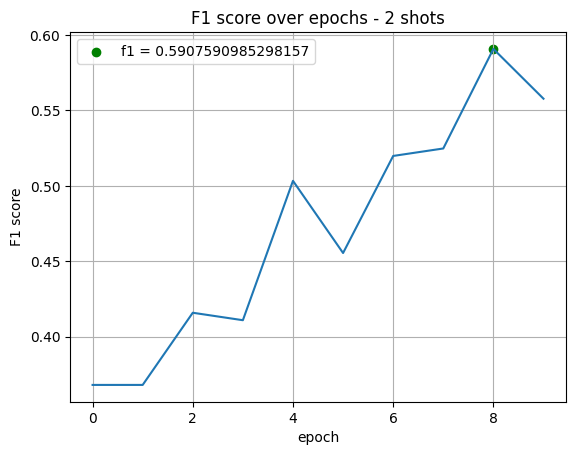

In [95]:
plt.plot(history)
plt.scatter(
    np.argmax(history),
    np.max(history),
    label = f"f1 = {np.max(history)}",
    c = "green"
)

plt.grid()
plt.title(f"F1 score over epochs - {n_shots} shots")
plt.xlabel("epoch")
plt.ylabel("F1 score")
plt.legend()

Text(0.5, 1.0, 'Confusion Matrix FUNSD - 2 shots')

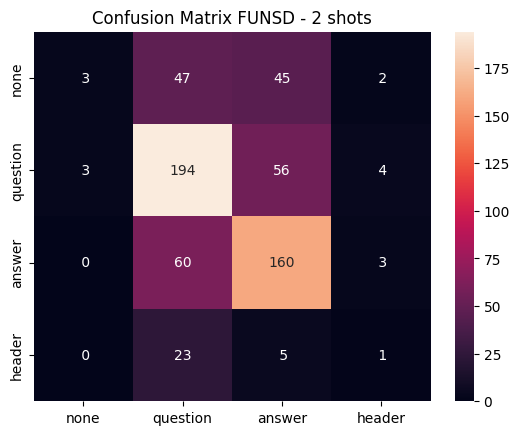

In [96]:
df = pd.DataFrame(
    confusion_matrix.to("cpu").numpy(),
    index = class_names,
    columns=class_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - {n_shots} shots")